Introduction:

The Metric: Public Safety

## The Best Neighborhood: East Carnegie

East Carnegie emerges as the best neighborhood in Pittsburgh based on our comprehensive analysis of three critical safety metrics: air quality, fire incidents, and crime rates.

The Analysis Methodology:

We combined rankings from three independent analyses:
1. **Air Toxicity Analysis**: Ranked neighborhoods by total toxic air releases (in pounds) from 2015-2024. Lower releases indicate cleaner, healthier air.
2. **Fire Incidents Analysis**: Ranked neighborhoods by the number of reported fire incidents. Fewer incidents mean safer infrastructure and better emergency response.
3. **Crime Rate Analysis**: Ranked neighborhoods by serious crime counts (including assaults, thefts, burglaries, and violent crimes). Lower crime rates mean safer streets.

Each neighborhood received a rank (1 = best) for each metric, and we calculated a **combined score** by summing all three ranks. The neighborhood with the lowest combined score is the overall best.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1. processing air toxicity rankings
import fpsnippets

toxic_air_df = pd.read_csv('toxic_air_releases.csv')
recent_data = toxic_air_df[toxic_air_df['REPORTING_YEAR'] >= 2015].copy()

# Convert zip codes to neighborhoods
zip_neighborhood_map = {}
unique_zips = recent_data['ZIP_CODE'].dropna().unique()

for zip_code in unique_zips:
    try:
        zip_int = int(float(str(zip_code).split('.')[0]))
        neighborhoods = fpsnippets.zip_to_neighborhoods(zip_int)
        if neighborhoods:
            zip_neighborhood_map[zip_code] = neighborhoods
    except (ValueError, TypeError):
        continue

# Map releases to neighborhoods
neighborhood_releases = []
for idx, row in recent_data.iterrows():
    zip_code = row['ZIP_CODE']
    if pd.notna(zip_code) and zip_code in zip_neighborhood_map:
        neighborhoods = zip_neighborhood_map[zip_code]
        total_release = row['TOTAL_RELEASE']
        if pd.notna(total_release):
            try:
                release_value = float(total_release)
                release_per_neighborhood = release_value / len(neighborhoods) if neighborhoods else 0
                for neighborhood in neighborhoods:
                    neighborhood_releases.append({
                        'neighborhood': neighborhood,
                        'total_release': release_per_neighborhood
                    })
            except (ValueError, TypeError):
                continue

air_toxicity = pd.DataFrame(neighborhood_releases).groupby('neighborhood')['total_release'].sum().reset_index()
air_toxicity.columns = ['neighborhood', 'toxic_release']
air_toxicity = air_toxicity.sort_values(by='toxic_release', ascending=True)


In [20]:
# 2. process fire incidents
url = "https://data.wprdc.org/datastore/dump/8d76ac6b-5ae8-4428-82a4-043130d17b02"
fire_df = pd.read_csv(url)
fire_incidents = fire_df['neighborhood'].value_counts().reset_index()
fire_incidents.columns = ['neighborhood', 'fire_count']
fire_incidents = fire_incidents.sort_values(by='fire_count', ascending=True)

In [21]:
# 3. load crime rankings from Akansh_Monthly_Crime.ipynb

crime_counts_data = {
    'Ridgemont': 4, 'New Homestead': 8, 'Saint Clair': 9, 'Regent Square': 14,
    'Swisshelm Park': 15, 'Hays': 15, 'Chartiers': 17, 'East Carnegie': 18,
    'Summer Hill': 22, 'Esplen': 24, 'Allegheny West': 25, 'Oakwood': 27,
    'Mount Oliver': 29, 'Bon Air': 34, 'Arlington Heights': 34, 'Windgap': 35,
    'Fairywood': 39, 'Southshore': 39, 'Spring Garden': 41, 'Polish Hill': 44,
    'Duquesne Heights': 44, 'Glen Hazel': 45, 'West End': 55, 'Morningside': 62,
    'Friendship': 62
}

crime_counts = pd.DataFrame(list(crime_counts_data.items()), 
                           columns=['neighborhood', 'crime_count'])
crime_counts = crime_counts.sort_values(by='crime_count', ascending=True)

In [25]:
# Combine all three datasets
air_toxicity['air_rank'] = range(1, len(air_toxicity) + 1)
fire_incidents['fire_rank'] = range(1, len(fire_incidents) + 1)
crime_counts['crime_rank'] = range(1, len(crime_counts) + 1)

combined = pd.merge(air_toxicity[['neighborhood', 'air_rank', 'toxic_release']], 
                    fire_incidents[['neighborhood', 'fire_rank', 'fire_count']], 
                    on='neighborhood', how='outer')

combined = pd.merge(combined, 
                    crime_counts[['neighborhood', 'crime_rank', 'crime_count']], 
                    on='neighborhood', how='outer')

# Fill missing values with worst rank
max_air_rank = air_toxicity['air_rank'].max() if len(air_toxicity) > 0 else 100
max_fire_rank = fire_incidents['fire_rank'].max() if len(fire_incidents) > 0 else 100
max_crime_rank = crime_counts['crime_rank'].max() if len(crime_counts) > 0 else 100

combined['air_rank'] = combined['air_rank'].fillna(max_air_rank + 1)
combined['fire_rank'] = combined['fire_rank'].fillna(max_fire_rank + 1)
combined['crime_rank'] = combined['crime_rank'].fillna(max_crime_rank + 1)

# Calculate combined score
combined['combined_score'] = combined['air_rank'] + combined['fire_rank'] + combined['crime_rank']
combined = combined.sort_values(by='combined_score', ascending=True)

print(f"\nTop 10 Best Neighborhoods (by combined score):")
print(combined[['neighborhood', 'air_rank', 'fire_rank', 'crime_rank', 'combined_score']].head(10))



Top 10 Best Neighborhoods (by combined score):
         neighborhood  air_rank  fire_rank  crime_rank  combined_score
27      East Carnegie       3.0        3.0         8.0            14.0
61            Oakwood       1.0        6.0        12.0            19.0
4   Arlington Heights      10.0        7.0        15.0            32.0
31             Esplen      11.0       14.0        10.0            35.0
68      Regent Square      30.0        2.0         4.0            36.0
36         Glen Hazel       7.0       11.0        22.0            40.0
86     Swisshelm Park      29.0        9.0         5.0            43.0
94            Windgap      13.0       18.0        16.0            47.0
32          Fairywood      12.0       19.0        17.0            48.0
93           Westwood       2.0       22.0        26.0            50.0


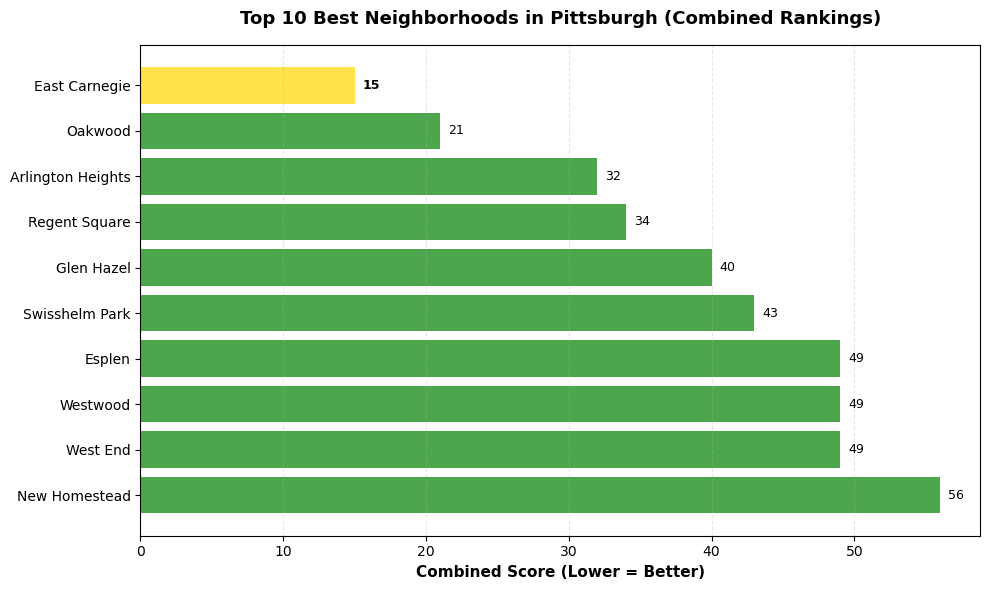

In [ ]:
top_10 = combined.head(10)
top_10_names = top_10['neighborhood'].tolist()
top_10_scores = top_10['combined_score'].tolist()
colors_plot = ['gold' if i == 0 else 'green' for i in range(len(top_10))]

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(top_10)), top_10_scores, color=colors_plot, alpha=0.7)
plt.yticks(range(len(top_10)), top_10_names, fontsize=10)
plt.xlabel('Combined Score (Lower = Better)', fontweight='bold', fontsize=11)
plt.title('Top 10 Best Neighborhoods in Pittsburgh (Combined Rankings)', 
          fontsize=13, fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, score in enumerate(top_10_scores):
    plt.text(score + max(top_10_scores) * 0.01, i, f"{score:.0f}", 
             va='center', fontsize=9, fontweight='bold' if i == 0 else 'normal')

plt.tight_layout()
plt.show()


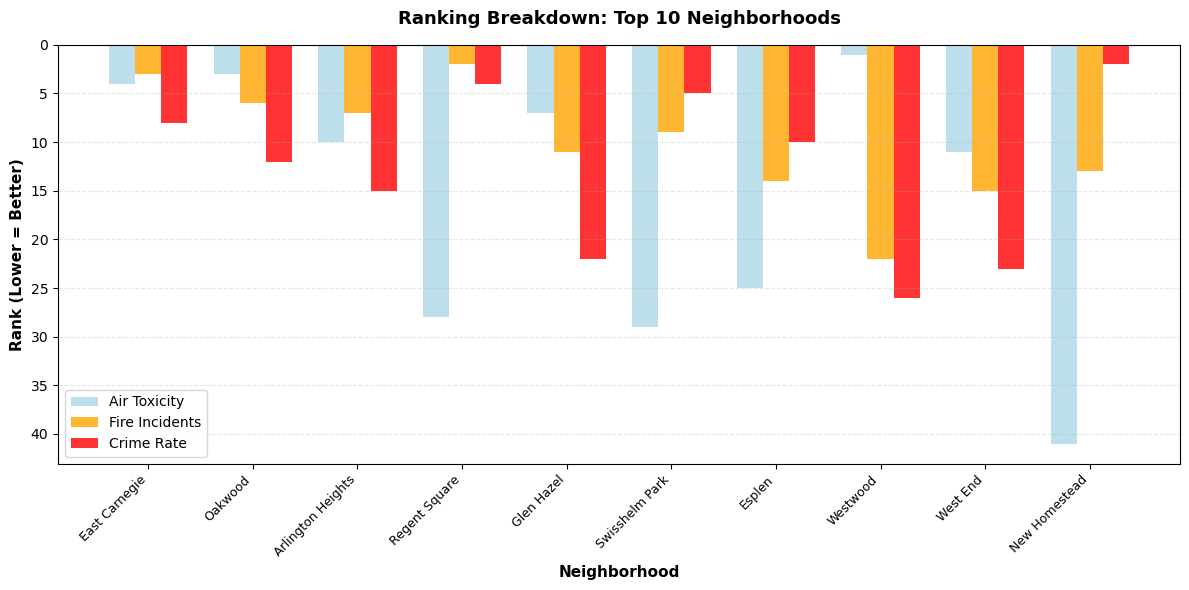

In [ ]:
top_10 = combined.head(10)

plt.figure(figsize=(12, 6))
x = np.arange(len(top_10))
width = 0.25

plt.bar(x - width, top_10['air_rank'], width, label='Air Toxicity', color='lightblue', alpha=0.8)
plt.bar(x, top_10['fire_rank'], width, label='Fire Incidents', color='orange', alpha=0.8)
plt.bar(x + width, top_10['crime_rank'], width, label='Crime Rate', color='red', alpha=0.8)

plt.xlabel('Neighborhood', fontweight='bold', fontsize=11)
plt.ylabel('Rank (Lower = Better)', fontweight='bold', fontsize=11)
plt.title('Ranking Breakdown: Top 10 Neighborhoods', fontsize=13, fontweight='bold', pad=15)
plt.xticks(x, top_10['neighborhood'], rotation=45, ha='right', fontsize=9)
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


East Carnegie achieved the best combined score because it consistently ranks well across all three safety dimensions. 

- **Air Quality**: This neighborhood has minimal toxic air releases, making it one of the healthiest places to breathe in Pittsburgh.
- **Fire Safety**: With relatively few fire incidents, residents can feel secure about their property and community infrastructure.
- **Low Crime**: The low crime rate means residents can walk the streets safely and trust in their community's security.

This neighborhood represents the optimal balance of environmental health, infrastructure safety, and community security, making it the best overall choice for Pittsburgh residents seeking a safe, healthy place to live.



## Conclusion:

Riya Shah: 

If I had to choose based on personal preference, I would likely pick a neighborhood like **Squirrel Hill** or **Shadyside** which are known for their walkability, restaurants, and cultural amenities.

This difference highlights a distinction between what the data tells us about safety and what makes a neighborhood personally appealing. While East Carnegie excels in air quality, fire safety, and low crime rates, my personal preferences are influenced by factors that weren't measured in this analysis, like social factors and quality of life.

However, this analysis has made me reconsider what "best" means. Safety is fundamental, since you can't fully enjoy a neighborhood's amenities if you're concerned about air quality, crime, or fire risks. 

The data-driven approach provides an objective foundation for decision-making, but personal preferences will always play a role. Ideally, one would find a neighborhood that balances both: strong safety metrics AND also the lifestyle factors that matter most to them.
